# Работа с данными: Кинопоиск

### Щеглова Ксения, BAE'25

В данном проекте исследуются данные по некоторой выборке фильмов с сайта Кинопоиск. В первой части проекта проводится парсинг данных с использованием библиотек Selenium и BeautifulSoup и регулярных выражений. Во второй части исследуются собранные данные: проводится построение графиков с помощью библиотек Matplotlib и Pandas, рассчитываются некоторые статистические показатели с помощью библиотеки SciPy и строится граф с помощью библиотеки NetWorkX. 


### Структура

##### Раздел 1: Парсинг данных (1.1 Подготовка шаблона - 1.2 Сбор ссылок - 1.3 Сбор данных)

##### Раздел 2: Исследование данных ( 2.1 Визуализация - 2.2 Статистические показатели - 2.3 Графы)





### Подготовка

In [1]:
import requests
import time
from bs4 import BeautifulSoup as BS
from selenium import webdriver
import re
import pandas as pd
import numpy as np
import matplotlib as mlt
import matplotlib.pyplot as plt
import math
import random
import scipy
import networkx as nx

#### Обозначения переменных:

df - временный датафрейм

df_work - датафрейм, в которым находятся основные данные

/value/_example - временная переменная со значением value

## Раздел 1: Парсинг данных

Мы хотим собрать таблицу, содеражащую следующую информацию о фильмах: название, лучшая оценка, рейтинг, количество оценок, страна, год, бюджет и актёрский состав. 


Во время подготовки  возникла проблема: Кинопоиск не позволяет парсить данные, даже через Selenium. Поэтому в код были добавлены таймеры, что существенно затормозило процесс. В связи с этим, собраны не все данные с сайтов, однако их достаточно для написания кода. В будущем можно расширить базу данных, используя этот же код.

### 1.1. Подготовка шаблона

Для начала посмотрим, как храняться данные на странице каждого фильма и составим шаблон, который применим ко всем страницам. Для примера будем смотреть данную страницу: https://www.kinopoisk.ru/film/462682/

Получать html страницы будем, используя Selenium и BeautifulSoup.

In [2]:
url_example = 'https://www.kinopoisk.ru/film/462682/'
driver = webdriver.Chrome()
driver.get(url_example)
soup = BS(driver.page_source, 'html.parser')
driver.quit()
print(soup.prettify())

<html>
 <head>
  <meta content="width=device-width" name="viewport"/>
  <meta charset="utf-8"/>
  <title data-tid="57f72b5">
   Волк с Уолл-стрит — смотреть онлайн — Кинопоиск
  </title>
  <meta content="#1f1f1f" data-tid="57f72b5" name="theme-color"/>
  <meta content="yes" data-tid="57f72b5" name="apple-mobile-web-app-capable"/>
  <meta content="black" data-tid="57f72b5" name="apple-mobile-web-app-status-bar-style"/>
  <meta content="Кинопоиск" data-tid="57f72b5" name="apple-mobile-web-app-title"/>
  <meta content="app-id=477718890, ct=kp-web, pt=214944, mt=8" data-tid="57f72b5" name="apple-itunes-app"/>
  <meta content="Кинопоиск" data-tid="57f72b5" name="application-name"/>
  <meta content="121953784483000" data-tid="57f72b5" property="fb:app_id"/>
  <meta content="152308956519" data-tid="57f72b5" property="fb:pages"/>
  <meta content="Кинопоиск" data-tid="57f72b5" property="og:site_name"/>
  <meta content="#000" data-tid="57f72b5" name="msapplication-TileColor"/>
  <meta content="h

Данные храняться в формате json в следующем виде:

1. Название:  "Movie","url":"https://kinopoisk.ru/film/462682/","name":"Волк с Уолл-стрит"

2. Лучшая оценка, рейтинг, количество оценок: "aggregateRating":{"@type":"AggregateRating","bestRating":10,"ratingValue":7.973,"ratingCount":1116335}

3. Страна: "countryOfOrigin":["США"]

4. Год: "datePublished":"2013"

5. Актёры: "actor":[{"@type":"Person","name":"Леонардо ДиКаприо","url":"/name/37859"},{"@type":"Person","name":"Джона Хилл","url":"/name/581340"},{"@type":"Person","name":"Марго Робби","url":"/name/1682023"},{"@type":"Person","name":"Кайл Чандлер","url":"/name/28949"},{"@type":"Person","name":"Роб Райнер","url":"/name/5899"},{"@type":"Person","name":"П.Дж. Бирн","url":"/name/32376"},{"@type":"Person","name":"Джон Бернтал","url":"/name/551260"},{"@type":"Person","name":"Кристин Милиоти","url":"/name/1098850"},{"@type":"Person","name":"Жан Дюжарден","url":"/name/383195"},{"@type":"Person","name":"Мэттью МакКонахи","url":"/name/797"}]

6. Бюджет: "budget":{"__typename":"MoneyAmount","amount":100000000,"currency":{"__typename":"Currency","symbol":"$"}}



Я испытала сложности с использованием готовых команд для поиска данных в данном формате. Поэтому для поиска будут использоваться регулярные выражения. 

Ниже представлены коды с комментариями, как с помощью re удалось собрать нужную и очистить нужную информацию 

In [3]:
# Чтобы работать с регулярными выражениями, преобразуем нашу переменную в строку
soup_example = str(soup)

In [4]:
# извлекаем название и приводим его к хорошему виду
title_example = re.findall('"@type":"Movie","url":"https://kinopoisk.ru/film/\d+/","name":"[^"]+"',soup_example)
title_example = title_example[0].split('"')[-2]
title_example
# Мы использовали регулярные выражения \d+ (любой набор цифр)(означающее номер фильма, по которому находится ссылка на него) и  [^"]+ (любой набор из символов любого размера кроме двойных кавычек)(обозначающее название фильма)

'Волк с Уолл-стрит'

In [5]:
#извлекаем рейтинг, лучшую оценку и количество оценок
ratings_example = re.findall('"aggregateRating":{"@type":"AggregateRating","bestRating":\d+,"ratingValue":\d.\d+,"ratingCount":\d+}', soup_example)
ratings_example
# BestRating представлен числом от 0 до 10
# ratingValue имеет вид d.ddd
# ratingCount - целое число

['"aggregateRating":{"@type":"AggregateRating","bestRating":10,"ratingValue":7.974,"ratingCount":1117664}',
 '"aggregateRating":{"@type":"AggregateRating","bestRating":10,"ratingValue":7.974,"ratingCount":1117664}']

In [6]:
# Приводим к хорошему виду
# Данные разделены запятыми. Разделим их на слова и будем использовать срезы, чтобы получить необходимое число.
# Сразу же переведём их в нужный нам формат
ratings_example_split = ratings_example[0].split(',')
ratings_example
bestRating_example = int(ratings_example_split[1][13:len(ratings_example_split[1])])
ratingValue_example = float(ratings_example_split[2][14:len(ratings_example_split[2])])
ratingCount_example = int(ratings_example_split[3][14:len(ratings_example_split[3])-1]) 
print(bestRating_example)
print(ratingValue_example)
print(ratingCount_example)

10
7.974
1117664


In [7]:
# Извлекаем название страны, год, бюджет
country_example = re.findall('"countryOfOrigin":\[[^\]]+\]', soup_example)[0].split('"')[-2]
date_example = re.findall('"datePublished":"\d+"',soup_example)[0].split('"')[-2]

print(country_example)
print(date_example)

США
2013


In [8]:
#Извлекаем бюдежет
budget_example = re.findall('"budget":{"__typename":"MoneyAmount","amount":\d+,"currency":{"__typename":"Currency","symbol":"[^"]"}}',soup_example)[0].split('"')
budget_example = [int(budget_example[8][1:-1]),budget_example[-2]]
budget_example

[100000000, '$']

In [9]:
# Извлекаем список актёров
actors_example = re.findall('"actor":\[[^\]]+\]',soup_example)

# Разбиваем строку на список из имён атёров
actors_example = actors_example[0][9:len(actors_example[0])-1]
actors_example=actors_example.split('},{')

# Преобразуем в список
actors_names_example = []
for k in actors_example:
    actors_names_example.append(k.split(',')[-2][8:-1])

# Каждый элемент в списке очищаем от ненужных символов
actors_names_example

['Леонардо ДиКаприо',
 'Джона Хилл',
 'Марго Робби',
 'Кайл Чандлер',
 'Роб Райнер',
 'П.Дж. Бирн',
 'Джон Бернтал',
 'Кристин Милиоти',
 'Жан Дюжарден',
 'Мэттью МакКонахи']

Собранные данные собираем в датафрейм и сохраняем.

In [10]:
df_example = pd.DataFrame({'title':[title_example],'bestRating':[bestRating_example],'ratingValue':[ratingValue_example],'ratingCount':[ratingCount_example],'country':[country_example],'date':[date_example],'budget':[budget_example],'actors':[actors_names_example],'link':['/film/462682/']})
df_example.to_csv('films_data21.csv',index=False,encoding='utf-8')
df_example

,title,bestRating,ratingValue,ratingCount,country,date,budget,actors,link
0,Волк с Уолл-стрит,10,7.974,1117664,США,2013,"[100000000, $]","[Леонардо ДиКаприо, Джона Хилл, Марго Робби, К...",/film/462682/


### 1.2 Сбор ссылок

Теперь когда мы можем получить информацию про каждый фильм по ссылке, нам нужно собрать список со всеми ссылками. 

Мы будем парсить фильмы в жанре драма с страниц https://www.kinopoisk.ru/lists/movies/genre--drama/?page=[номер страницы]. 

In [11]:
df_links = pd.read_csv('df_links.csv')

In [13]:
for s in range(1,12): #номер парсируемых страниц
    try:
        if str(s) not in df_links: #берём s-1, так как номера в колонках сдвинуты на 1 
            url_page = f'https://www.kinopoisk.ru/lists/movies/genre--drama/?page={s}'
            #открываем браузер и ищем необходимую страницу
            driver = webdriver.Chrome()
            driver.get(url_page)
            my_soup = BS(driver.page_source, 'html.parser')
            driver.quit()
            #С помощью BeautifulSoup и регулярных выражений ищем ссылки на фильмы
            films = my_soup.find_all("div", class_="styles_root__ti07r") #извлекаем класс, в котором лежат ссылки
            films_str = str(films)
            films_list = re.findall('href="/film/\d+/"',films_str) #извлекаем сами ссылки
            films_list=list(set(films_list)) #избавляемся от дубликатов
            for i in range (len(films_list)):
                films_list[i] = films_list[i][6:-1] #убираем лишние символы
            new_column = pd.DataFrame({str(s):films_list})
            df_links = pd.concat([df_links,new_column],axis=1) #добаляем лист в дата фрейм
            time.sleep(random.randint(5,15)) #отдыхаем  5-15 секунд
        
    except:
        time.sleep(15) #заснули на 15 секунд

df_links.to_csv('df_links.csv',index=False)


# 1.3 Сбор данных

В шаге 1.1 мы создали шаблон для поиска информации по одной ссылки, в шаге 1.2 собрали необходимые ссылки. К найденым ссылкам применяем шаблон и собираем дата фрейм df_links2.csv. 

In [14]:
df_links = pd.read_csv('df_links.csv')

In [15]:
#собираем все колонки в список 
all_urls = []
for column_name in df_links:
    all_urls += list(df_links[column_name].dropna())
    

У нас уже есть датафрейм,в котором есть часть ссылок. Чтобы не парсить всё по 100 раз, извлекаем из него ссылки, данные с которых уже собраны

In [16]:
urls_rest = []
df_work = pd.read_csv("films_data24.csv") #считываем существующий файл
links_already_exist = list(df_work.dropna(how='all')['link']) #собираем ссылки фильмов, по которым есть данные 
for url_i in all_urls:
    if url_i not in links_already_exist:
        urls_rest.append(url_i)

In [17]:
# В списке urls_rest находятся ссылки, которые нам нужно парсить.
len(urls_rest) 

89

Ниже представлен код с парсингом.

In [19]:
# Дисклеймер: Этот код будет выполняться долго
#Создаём временные списки, куда будут записываться данные  
title = []
bestRating = []
ratingValue = []
ratingCount = []
country = []
date = []
actors = []
budget = []
links = []

# Счётчик (нужен для того, что бы добавлять паузы)
rest = 1


for film_key in urls_rest[:1]: #Количество ссылок, которые будем парсить 
    try:
        rest+=1
        
        #условие при котором программа делаем перерыв
        if rest % 10 == 0:
            df = pd.DataFrame({'title':title,'bestRating':bestRating,'ratingValue':ratingValue,'ratingCount':ratingCount,'country':country,'date':date,'budget':budget,'actors':actors,'link':links})
            df = df.dropna(how='all')
            
            #сохраняем временный файл, на случай если что-то пойдёт не так
            try:
                #перезаписываем в прошлый временный файл
                df.to_csv('temp_table1.csv',index=False)
            except:
                #создаём новый врем.файл, если программа не хочет перезаписывать в уже существующий
                df.to_csv(f'temp_table_err{rest}.csv',index=False)
            time.sleep(random.randint(180,300)) #спим от 3 до 5 минут
        
        url_example = f'https://www.kinopoisk.ru{film_key}'
#         print(rest) # Вывоводим счётчик, чтобы отслуживать на каком этапе сейчас программа        
        
        # Достаём html 
        driver = webdriver.Chrome()
        driver.get(url_example)
        soup = BS(driver.page_source, 'html.parser')
        driver.quit()

        soup_example = str(soup)
        
        #Собираем данные 
        #Условие if... else... нужно на случай если программа не найдёт данные сооответствующие нашему регулярному выражению и не возникло никаких ошибок
        #Если программа не найдёт нужную информацию, она запишет в таблицу NaN
        
        title_example = re.findall('"@type":"Movie","url":"https://kinopoisk.ru/film/\d+/","name":"[^"]+"',soup_example)
        if len(title_example) != 0:
            title.append(title_example[0].split('"')[-2])
        else:
            title.append(np.nan)
        ratings_example = re.findall('"aggregateRating":{"@type":"AggregateRating","bestRating":\d+,"ratingValue":\d.\d+,"ratingCount":\d+}', soup_example)
        
        
        if len(ratings_example) != 0:
            ratings_example_split = ratings_example[0].split(',')
            bestRating.append(int(ratings_example_split[1][13:len(ratings_example_split[1])]))
            ratingValue.append(float(ratings_example_split[2][14:len(ratings_example_split[2])]))
            ratingCount.append(int(ratings_example_split[3][14:len(ratings_example_split[3])-1]) )
        else:
            bestRating.append(np.nan)
            ratingValue.append(np.nan)
            ratingCount.append(np.nan)

        if len(re.findall('"countryOfOrigin":\[[^\]]+\]', soup_example)) != 0:
            country.append(re.findall('"countryOfOrigin":\[[^\]]+\]', soup_example)[0].split('"')[-2])
        else:
            country.append(np.nan)

        date_example = re.findall('"datePublished":"\d+"',soup_example)
        if len(date_example) != 0:
            date.append(date_example[0].split('"')[-2])
        else: 
            date.append(np.nan)

        budget_example = re.findall('"budget":{"__typename":"MoneyAmount","amount":\d+,"currency":{"__typename":"Currency","symbol":"[^"]"}}',soup_example)
        if len(budget_example) != 0:
            budget_example = budget_example[0].split('"')
            budget_example = int(budget_example[8][1:-1]),budget_example[-2]
            budget.append(budget_example)
        else:
            budget.append(np.nan)

        actors_example = re.findall('"actor":\[[^\]]+\]',soup_example)
        if len(actors_example) != 0: 
            actors_example = actors_example[0][9:len(actors_example[0])-1]
            actors_example = actors_example.split('},{')
            actors_names_example = []
            for k in actors_example:
                actors_names_example.append(k.split(',')[-2][8:-1])
            actors.append(actors_names_example)
        else:
            actors.append(np.nan)
            
        # если Кинопоиск начнёт ругаться, что выведет страницу с требованием подтвердить, что мы человек.
        # в этом случае программа запишет NaN во все списки
        # поэтому мы в колонку links мы тоже запишем NaN и отправим программу спать на 5-10 минут.
        
        if (title_example==[]) and (actors_example==[]) and (date_example==[]) and (ratings_example==[]):
            links.append(np.nan)
            time.sleep(random.randint(300,600))
        else:
            links.append(film_key)
            
    except:
        time.sleep(random.randint(300,600))
        # если программа выведет ошибку, отправим её спать (скорее всего это произойдёт из-за того, что Кинопоиск запретит парсинг)
        
df = pd.DataFrame({'title':title,'bestRating':bestRating,'ratingValue':ratingValue,'ratingCount':ratingCount,'country':country,'date':date,'budget':budget,'actors':actors,'link':links})
df=df.dropna(how='all') #избалвяемся от строк, где все элементы NaN
df_work=pd.concat([df_work,df]) #объединяем только что собранный ДФ с уже существующим ДФ.
df_work.to_csv("films_data24.csv",index=False) #сохраняем всё.


### Раздел 2: Работа с данными

### 2.0 "Очистка" данных

In [20]:
df_work = pd.read_csv("films_data24.csv")
df_work = df_work.dropna(how='all')
df_work = df_work.drop_duplicates()
df_work

,title,bestRating,ratingValue,ratingCount,country,date,budget,actors,link,ratingValue_qcut
0,Во всё тяжкое,10.0,7.307,294929.0,США,2018.0,NaN,"['Джонни Депп', 'Розмари ДеУитт', 'Одесса Янг'...",/film/1047881/,NaN
1,Общество мертвых поэтов,10.0,8.236,197780.0,США,1989.0,"(16400000, '$')","['Робин Уильямс', 'Роберт Шон Леонард', 'Итан ...",/film/4996/,NaN
2,Неадекватные люди,10.0,7.663,177563.0,Россия,2010.0,"(100000, '$')",NaN,/film/542581/,NaN
3,Славные парни,10.0,8.123,189006.0,США,1990.0,"(25000000, '$')","['Роберт Де Ниро', 'Рэй Лиотта', 'Джо Пеши', '...",/film/350/,NaN
4,Левша,10.0,7.463,165860.0,Гонконг,2015.0,"(30000000, '$')","['Джейк Джилленхол', 'Рэйчел Макадамс', 'Форес...",/film/573990/,NaN
...,...,...,...,...,...,...,...,...,...,...
585,Без меня,10.0,7.146,110873.0,Россия,2018.0,NaN,NaN,/film/1049103/,NaN
586,Сладкий ноябрь,10.0,7.741,130282.0,США,2001.0,"(40000000, '$')","['Киану Ривз', 'Шарлиз Терон', 'Джейсон Айзекс...",/film/3795/,NaN
587,Доктор Лиза,10.0,8.217,124710.0,Россия,2020.0,"(72000000, '₽')",['Анджей Хыра'],/film/1254059/,NaN
588,Темные воды,10.0,7.775,124568.0,США,2019.0,NaN,"['Марк Руффало', 'Энн Хэтэуэй', 'Тим Роббинс',...",/film/1228069/,NaN


Я ошиблась с выбором записи бюджета фильма. Поэтому следующий год нужен для того, чтобы разделить в таблице число и валюту и создать отдельные колонки.

In [21]:
budget_amount = []
budget_currency = []
list_budget = list(df_work['budget'])
for i in range(len(list_budget)):
    if type(list_budget[i]) == str:
#         print(list_budget[i])
        list_budget[i] = list_budget[i][1:-1].split(',')  
        list_budget[i][0]=float(list_budget[i][0])
        list_budget[i][1]=str(list_budget[i][1])[1:]
    else:
        list_budget[i]=[np.nan,np.nan]
    budget_amount.append(list_budget[i][0])
    budget_currency.append(list_budget[i][1])
df_work['budget_amount'] = pd.Series(budget_amount)
df_work['budget_currency'] = pd.Series(budget_currency)

In [22]:
df_work.head(3)

,title,bestRating,ratingValue,ratingCount,country,date,budget,actors,link,ratingValue_qcut,budget_amount,budget_currency
0,Во всё тяжкое,10.0,7.307,294929.0,США,2018.0,NaN,"['Джонни Депп', 'Розмари ДеУитт', 'Одесса Янг'...",/film/1047881/,NaN,NaN,NaN
1,Общество мертвых поэтов,10.0,8.236,197780.0,США,1989.0,"(16400000, '$')","['Робин Уильямс', 'Роберт Шон Леонард', 'Итан ...",/film/4996/,NaN,16400000.0,'$'
2,Неадекватные люди,10.0,7.663,177563.0,Россия,2010.0,"(100000, '$')",NaN,/film/542581/,NaN,100000.0,'$'


### 2.1 Визуализация

Рассмотрим собранные данные на графиках

##### 2.1.1. Разбиение рейтинга фильмов

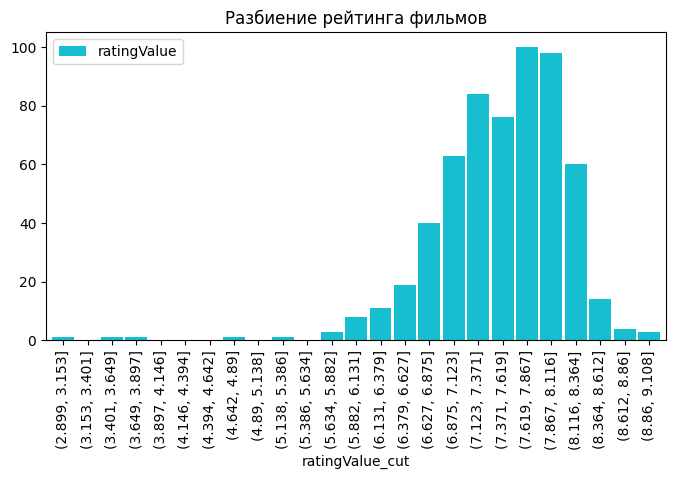

<Figure size 640x480 with 0 Axes>

In [23]:
df_work['ratingValue_cut'] = pd.cut(df_work['ratingValue'], 25) #Разделяем данные на равные интервалы

df_work.groupby('ratingValue_cut')['ratingValue'].count().plot.bar(color='C9',align='center',width=0.9,figsize=(8,4))

plt.title('Разбиение рейтинга фильмов')
plt.legend()
plt.show()
plt.savefig('Разбиение рейтинга фильмов.png')

##### 2.1.2 Доля стран по количеству фильмов в выборке

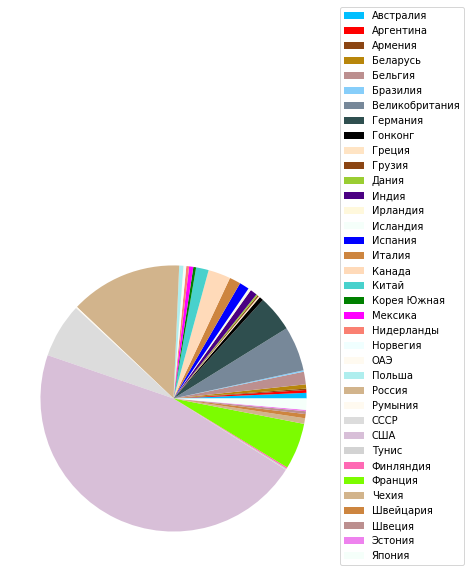

<Figure size 640x480 with 0 Axes>

In [24]:
plt.figure(figsize=(10, 6), dpi=72)
plt.pie(df_work.groupby(df_work.country)['ratingValue'].count(),colors = random.choices(list(mlt.colors.CSS4_COLORS.values()),k = df_work.groupby(df_work.country).ngroups))
plt.legend(labels=df_work.groupby(df_work.country).groups,loc=(1,0))
# покрасили в рандомные цвета
plt.show()
plt.savefig('Распределение по странам.png')

##### 2.1.3 Разброс оценок фильмов по годам

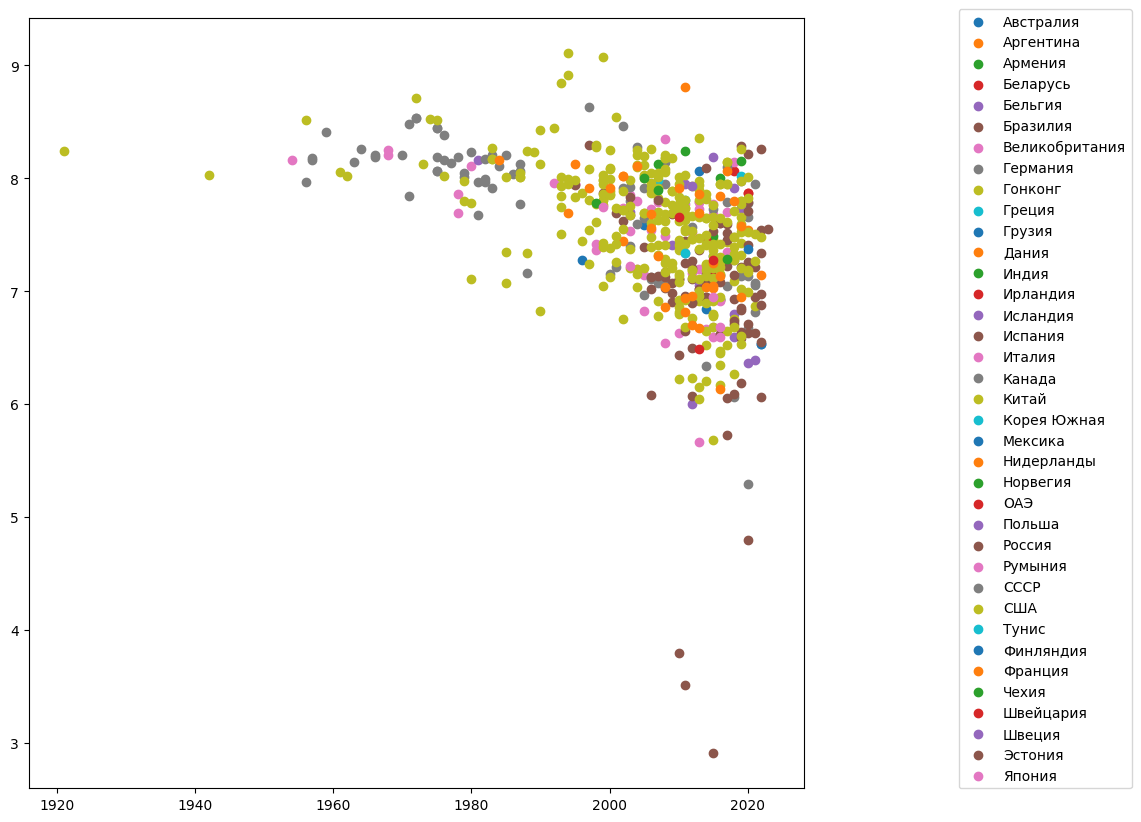

In [25]:
groups = df_work.groupby(df_work.country) #группируем по странам
plt.figure(figsize=(10,10))
for name, group in groups:
    plt.scatter(group.date,group.ratingValue,label = name)
plt.legend(loc=(1.2,0))
plt.savefig('Разброс оценок фильмов по годам.png')

### 2.2 Статистика

##### 2.2.1 Корреляция между показателями

Посчитаем корреляцию между следующими показателями: рейтинг фильма, кол-во просмотров, вложенный бюджет, год. Выберем только те фильмы, где бюджет представлен в валюте $. 



In [26]:
df_work_study = df_work.loc[df_work['budget_currency'] == "'$'" ][['ratingValue','ratingCount','budget_amount','date']].dropna()
correlations = df_work_study.corr()
correlations.style.background_gradient(cmap='coolwarm',vmin=-1,vmax=1)

,ratingValue,ratingCount,budget_amount,date
ratingValue,1.000000,0.516639,0.009067,-0.414689
ratingCount,0.516639,1.000000,0.192845,-0.006841
budget_amount,0.009067,0.192845,1.000000,0.134843
date,-0.414689,-0.006841,0.134843,1.000000


С помощью функции pearsonr оценим, насколько значим показатель корреляции (p-value)

In [27]:
from scipy.stats import pearsonr

In [28]:
for i in range(4):
    for j in range(i+1,4):
            print(df_work_study.columns[i],df_work_study.columns[j])
            print(pearsonr(df_work_study[df_work_study.columns[i]],df_work_study[df_work_study.columns[j]]))

ratingValue ratingCount
PearsonRResult(statistic=0.5166390316982415, pvalue=2.6959222209716517e-26)
ratingValue budget_amount
PearsonRResult(statistic=0.009067364764679287, pvalue=0.8629335333359511)
ratingValue date
PearsonRResult(statistic=-0.414688937976372, pvalue=1.3306637414348249e-16)
ratingCount budget_amount
PearsonRResult(statistic=0.1928450089283756, pvalue=0.00021013387156799867)
ratingCount date
PearsonRResult(statistic=-0.0068410386463713365, pvalue=0.8963677814940055)
budget_amount date
PearsonRResult(statistic=0.1348433733119978, pvalue=0.009904893713987456)


Корреляция между колонками, где p-value получилось меньше 0.05 является статистически значимой. В противном случае - статистически не значимой. 

Так, наш тест показал положительную корреляцию между количеством оценок и средней оценкой, между количеством оценок и вложенным бюджетом, а также отрицательную корреляцию между годом выхода фильма и средней оценкой. 

##### 2.2.2 Статистический тест 

Сделаем простой статистический тест. 
Будем проверять, правда ли, что новые фильмы лучше,чем более поздние.  

В качестве нулевой гипотезы возьмём следующее утверждение: средняя оценка фильмов до года X не отличается от средней оценки после года X. 

В качестве альтернативы возьмём утверждение: 
средняя оценка фильмов до года X больше средней оценки после года X. 

В качестве года Х возьмём медианный год

In [29]:
year_median = df_work.date.quantile(0.50)
year_median

2010.0

In [30]:
df_work_test_a = df_work.loc[df_work['date'] <= year_median][['ratingValue']].dropna() 
df_work_test_b = df_work.loc[df_work['date'] > year_median][['ratingValue']].dropna()
scipy.stats.ttest_ind_from_stats(mean1 = df_work_test_a.mean(), mean2 = df_work_test_b.mean(), nobs1 = df_work_test_a.count(), nobs2 =df_work_test_b.count() , std1 = df_work_test_a.std(),std2 = df_work_test_b.std(), alternative='greater')

Ttest_indResult(statistic=ratingValue    11.007986
dtype: float64, pvalue=ratingValue    4.773250e-26
dtype: float64)

Мы получили положительную статистику с очень низким p-value => отвергаем гипотезу в пользу альтернативы

##### 2.2.3 Линейная регрессия

Построим линюю регрессии средней оценки по годам

In [31]:
rV_by_year = df_work.groupby('date')['ratingValue'].mean()

In [32]:
scipy.stats.linregress(rV_by_year.index,rV_by_year, alternative='two-sided')

LinregressResult(slope=-0.015070194762824363, intercept=37.80026014894591, rvalue=-0.8103251370206698, pvalue=2.9180915902387974e-16, stderr=0.0013730060768141527, intercept_stderr=2.731242693555286)

In [33]:
x = rV_by_year.index
y = rV_by_year

In [34]:
res = scipy.stats.linregress(x,y, alternative='two-sided')

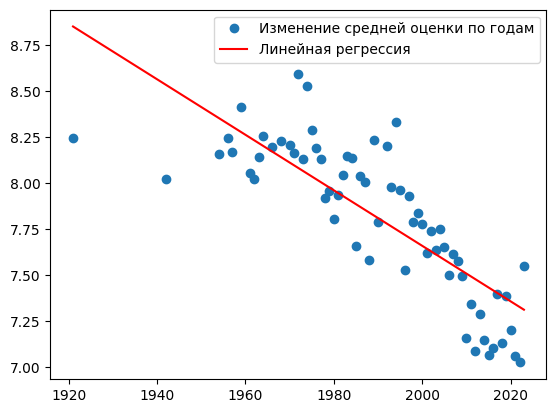

In [35]:
plt.plot(x, y, 'o' , label='Изменение средней оценки по годам')
plt.plot(x, res.intercept + res.slope*x, 'r', label='Линейная регрессия')
plt.legend()
plt.show()

### 2.3 Графы

Давайте построим граф, отражающий какие актёры чаще всего снимаются вместе. 

Для этого актёров из каждой группы разделим на пары и посчитаем, в скольких фильмах снялась каждая пара

In [36]:
actors = []
actors_dic = {}
for ind in range(df_work.actors.dropna(how='any').count()):
    if type(df_work.actors[ind]) == str:
        s = df_work[['actors']].dropna(how='any').iat[ind,0]
        m = s[2:-2].split("', '") #Приводим данные к читабельному виду.
        for i in range(len(m)-1):
            for j in range(i+1,len(m)):
                if tuple([m[i],m[j]]) in actors_dic.keys():
                    actors_dic[tuple([m[i],m[j]])] += 1
                else:
                    actors_dic[tuple([m[i],m[j]])] = 1
        actors = actors + m
        actors = list(set(actors))
        actors_dic

Нам будет неинтересно сомотреть на графы с актёрам, которые снимались с небольших кол-вом людей, поэтому уберём актёров, встречающихся меньше чем в 3 фильмах и пары, встречающиеся меньше двух раз.

Выбираем актёров, упоминались больше 25 раз

In [37]:
actors=sum((actors_dic.keys()),())
actors_unique = set(actors)
actors_for_graph = []
for k in actors_unique:
    if actors.count(k) > 25:
        actors_for_graph.append(k)


Выбираем рёбра для этих актёров  

In [38]:
actors_key_nets = {}
for key in actors_dic:
    if key[0] in actors_for_graph and key[1] in actors_for_graph and actors_dic[key]>1:
        actors_key_nets[key] = actors_dic[key]

Рисуем граф

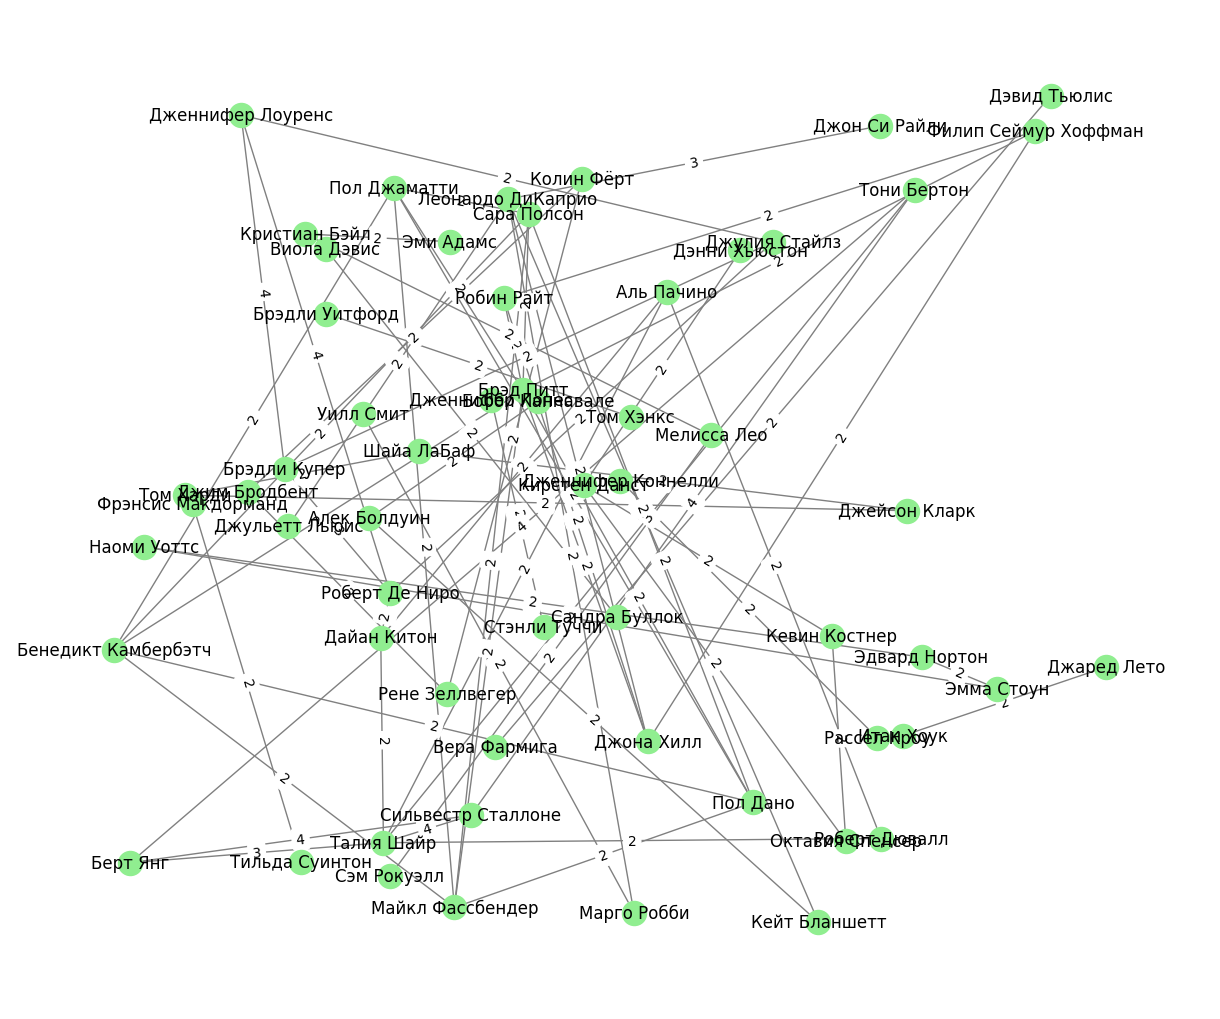

In [39]:
G = nx.Graph()
G.add_edges_from(actors_key_nets)
pos = nx.random_layout(G)
plt.figure(figsize=(12,10))
nx.draw(G,pos,with_labels = True,arrows=True,node_color= 'lightgreen',edge_color='grey')
nx.draw_networkx_edge_labels(G, pos, edge_labels=actors_key_nets)
plt.savefig('Граф связей актёров.png')

Числа на рёбрах означают количство фильмов, в которых актёры снялись вместе.